In [1]:
# ============================================================================
# MOD002691 - FINAL PROJECT: EFFICIENTNETB0 TRAINING
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# Train an EfficientNetB0 model with transfer learning for food image classification.
# This is Model 2 of 3 in a comparative study:
#
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# ============================================================================
# FAIR COMPARISON CONTROLS
# ============================================================================
#
# To ensure valid comparison, ALL models use IDENTICAL:
#   - Dataset (same train/val/test split, SHA-256 verified zero leakage)
#   - Image size (224x224 RGB)
#   - Batch size (32)
#   - Data augmentation pipeline
#   - Class weights (to handle 113:1 imbalance)
#   - Callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
#   - Evaluation metrics and methodology
#   - Maximum epochs (100) and early stopping patience (15)
#
# The ONLY difference is the model architecture itself.
#
# ============================================================================
# CHECKPOINT / RESUME SUPPORT
# ============================================================================
#
# This notebook supports interruption recovery for Google Colab sessions:
#   - Model checkpoints saved to Google Drive every 5 epochs
#   - Training history preserved in JSON format
#   - Cumulative training time tracked across sessions
#   - On resume: loads latest checkpoint and continues from last epoch
#
# ============================================================================

In [2]:
# ============================================================================
# CELL 2: ENVIRONMENT SETUP
# ============================================================================
# Displays runtime information for reproducibility documentation.
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("EFFICIENTNETB0 TRAINING")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

EFFICIENTNETB0 TRAINING
Execution:  2026-02-08 11:24:37
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [3]:
# ============================================================================
# CELL 3: IMPORTS AND GPU CONFIGURATION
# ============================================================================
# Core ML libraries. GPU memory growth enabled to prevent OOM errors.
# ============================================================================

import os
import json
import glob
import shutil
import zipfile
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive
drive.mount('/content/drive')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# GPU Configuration
print("=" * 70)
print("HARDWARE CONFIGURATION")
print("=" * 70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: Yes")
    print(f"GPU Device:    {{gpus[0].name}}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU Available: No (training will be slow)")

print(f"TensorFlow:    {{tf.__version__}}")
print(f"Random Seed:   {{SEED}}")

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

Mounted at /content/drive
HARDWARE CONFIGURATION
GPU Available: Yes
GPU Device:    {gpus[0].name}
TensorFlow:    {tf.__version__}
Random Seed:   {SEED}


In [4]:
# ============================================================================
# CELL 4: SHARED CONFIGURATION
# ============================================================================
# These parameters are IDENTICAL across all three model notebooks.
# This ensures a fair and valid comparison between architectures.
# ============================================================================

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)

# Dataset paths
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models_v2"
DRIVE_CHECKPOINT_DIR = f"{DRIVE_MODEL_DIR}/checkpoints/efficientnet"

# Image and batch configuration (IDENTICAL for all models)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 14

# Training configuration (IDENTICAL for all models)
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15
REDUCE_LR_PATIENCE = 5
REDUCE_LR_FACTOR = 0.5
MIN_LR = 1e-7

# Data augmentation configuration (IDENTICAL for all models)
AUGMENTATION_CONFIG = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

print(f"""
[Dataset]
  Source: {DATASET_ZIP}

[Image Configuration]
  Size:       {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels
  Batch Size: {BATCH_SIZE}
  Classes:    {NUM_CLASSES}

[Training Configuration]
  Max Epochs:    {MAX_EPOCHS}
  Early Stop:    {EARLY_STOPPING_PATIENCE} epochs patience
  LR Reduction:  factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}

[Data Augmentation]
  Rotation:        {AUGMENTATION_CONFIG['rotation_range']} degrees
  Width Shift:     {AUGMENTATION_CONFIG['width_shift_range']}
  Height Shift:    {AUGMENTATION_CONFIG['height_shift_range']}
  Shear:           {AUGMENTATION_CONFIG['shear_range']}
  Zoom:            {AUGMENTATION_CONFIG['zoom_range']}
  Horizontal Flip: {AUGMENTATION_CONFIG['horizontal_flip']}
""")

TRAINING CONFIGURATION

[Dataset]
  Source: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip

[Image Configuration]
  Size:       224x224 pixels
  Batch Size: 32
  Classes:    14

[Training Configuration]
  Max Epochs:    100
  Early Stop:    15 epochs patience
  LR Reduction:  factor=0.5, patience=5

[Data Augmentation]
  Rotation:        20 degrees
  Width Shift:     0.1
  Height Shift:    0.1
  Shear:           0.1
  Zoom:            0.1
  Horizontal Flip: True



In [5]:
# ============================================================================
# CELL 5: LOAD AND EXTRACT DATASET
# ============================================================================
# Extracts the deduplicated dataset prepared in the Dataset Preparation notebook.
# ============================================================================

print("=" * 70)
print("LOADING DATASET")
print("=" * 70)

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset: {DATASET_ZIP}")
print(f"Size:    {zip_size_mb:.1f} MB")

# Extract dataset
print(f"\nExtracting to: {LOCAL_DATASET}")
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)
print("Extraction complete.")

# Define paths
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

# Verify structure
print(f"\n[Dataset Structure]")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        raise FileNotFoundError(f"{split_name} directory not found: {split_dir}")

# Get class names
CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"\nClasses: {CLASS_NAMES}")

LOADING DATASET

Dataset: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip
Size:    2199.9 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

[Dataset Structure]
  Train:   14 classes, 84,582 images
  Val:     14 classes, 18,119 images
  Test:    14 classes, 18,141 images

Classes: ['apple', 'banana', 'bell_pepper_green', 'bell_pepper_red', 'carrot', 'cucumber', 'grape', 'lemon', 'onion', 'orange', 'peach', 'potato', 'strawberry', 'tomato']


In [6]:
# ============================================================================
# CELL 6: DATA GENERATORS WITH CLASS WEIGHTS
# ============================================================================
# Creates data generators with IDENTICAL augmentation settings.
# Computes class weights to address the 113:1 class imbalance.
# Uses EfficientNetB0-specific preprocessing (required for ImageNet weights).
# ============================================================================

print("=" * 70)
print("DATA GENERATORS")
print("=" * 70)

# Training generator with augmentation and model-specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    **AUGMENTATION_CONFIG
)

# Validation and test generators (no augmentation, only preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
print("\nCreating generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n[Generator Summary]")
print(f"  Train:      {train_generator.samples:,} images")
print(f"  Validation: {val_generator.samples:,} images")
print(f"  Test:       {test_generator.samples:,} images")

# Compute class weights to handle imbalance
print(f"\n[Class Weights]")
train_labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
CLASS_WEIGHTS = dict(enumerate(class_weights_array))

# Display imbalance info
class_counts = np.bincount(train_labels)
max_class = CLASS_NAMES[np.argmax(class_counts)]
min_class = CLASS_NAMES[np.argmin(class_counts)]
imbalance_ratio = np.max(class_counts) / np.min(class_counts)

print(f"  Largest:  {max_class} ({np.max(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmax(class_counts)]:.4f})")
print(f"  Smallest: {min_class} ({np.min(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmin(class_counts)]:.4f})")
print(f"  Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"\n  Class weights will be applied during training.")

DATA GENERATORS

Creating generators...
Found 84582 images belonging to 14 classes.
Found 18119 images belonging to 14 classes.
Found 18141 images belonging to 14 classes.

[Generator Summary]
  Train:      84,582 images
  Validation: 18,119 images
  Test:       18,141 images

[Class Weights]
  Largest:  apple (31,818 samples, weight=0.1899)
  Smallest: carrot (281 samples, weight=21.5003)
  Imbalance Ratio: 113.2:1

  Class weights will be applied during training.


In [7]:
# ============================================================================
# CELL 7: BUILD EFFICIENTNETB0 MODEL
# ============================================================================
# EfficientNetB0 transfer learning architecture:
#   - Pre-trained base from ImageNet (frozen initially)
#   - Custom classification head
#   - Two-phase training: head only, then fine-tune top layers
# ============================================================================

print("=" * 70)
print("BUILDING MODEL: EFFICIENTNETB0")
print("=" * 70)

# Load pre-trained EfficientNetB0
print("\nLoading EfficientNetB0 pre-trained on ImageNet...")
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model initially
base_model.trainable = False

print(f"Base model: {base_model.name}")
print(f"Layers:     {len(base_model.layers)}")

# Build complete model
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(name='gap'),
    layers.BatchNormalization(name='bn'),
    layers.Dropout(0.3, name='dropout'),
    layers.Dense(NUM_CLASSES, activation='softmax', name='output')
], name='SnapShelf_EfficientNet')

# Compile for Phase 1 (frozen base)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n[Model Architecture]")
print("-" * 70)
model.summary()

# Parameter count
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("-" * 70)
print(f"\n[Parameters]")
print(f"  Total:         {total_params:,}")
print(f"  Trainable:     {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")

BUILDING MODEL: EFFICIENTNETB0

Loading EfficientNetB0 pre-trained on ImageNet...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Base model: efficientnetb0
Layers:     238

[Model Architecture]
----------------------------------------------------------------------


Model: "SnapShelf_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn (BatchNormalization)         │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,625 (15.54 MB)

 Trainable params: 20,494 (80.05 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

----------------------------------------------------------------------

[Parameters]
  Total:         4,072,625
  Trainable:     20,494
  Non-trainable: 4,052,131


In [8]:
# ============================================================================
# CHECKPOINT DETECTION (Resume training if interrupted)
# ============================================================================
# Checks Google Drive for existing checkpoints from a previous session.
# For transfer learning: also tracks whether Phase 1 (frozen head training)
# has been completed, so we skip it on resume and go straight to fine-tuning.
# ============================================================================

print("=" * 70)
print("CHECKPOINT DETECTION")
print("=" * 70)

os.makedirs(DRIVE_CHECKPOINT_DIR, exist_ok=True)

# Check for existing checkpoints
existing_checkpoints = sorted(glob.glob(f"{DRIVE_CHECKPOINT_DIR}/epoch_*.keras"))
INITIAL_EPOCH = 0
PHASE1_COMPLETED = False
cumulative_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': [], 'lr': []}
cumulative_training_seconds = 0.0

if existing_checkpoints:
    latest_checkpoint = existing_checkpoints[-1]
    INITIAL_EPOCH = int(latest_checkpoint.split('epoch_')[-1].replace('.keras', ''))

    print(f"  Found {len(existing_checkpoints)} checkpoint(s)")
    print(f"  Latest: epoch {INITIAL_EPOCH}")
    print(f"  Resuming from epoch {INITIAL_EPOCH + 1}")

    # Load model from checkpoint (includes optimizer state)
    model = keras.models.load_model(latest_checkpoint)
    print("  Model loaded from checkpoint.")

    # Load previous history
    history_path = f"{DRIVE_CHECKPOINT_DIR}/training_history.json"
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            cumulative_history = json.load(f)
        print(f"  Previous history loaded ({len(cumulative_history['loss'])} epochs)")

    # Load cumulative training time
    time_path = f"{DRIVE_CHECKPOINT_DIR}/training_time.json"
    if os.path.exists(time_path):
        with open(time_path, 'r') as f:
            cumulative_training_seconds = json.load(f).get('total_seconds', 0.0)
        print(f"  Previous training time: {cumulative_training_seconds:.0f}s")

    # Check if Phase 1 was already completed
    phase_path = f"{DRIVE_CHECKPOINT_DIR}/phase_status.json"
    if os.path.exists(phase_path):
        with open(phase_path, 'r') as f:
            phase_status = json.load(f)
        PHASE1_COMPLETED = phase_status.get('phase1_completed', False)
        print(f"  Phase 1 completed: {PHASE1_COMPLETED}")

else:
    print("  No checkpoints found. Starting fresh from epoch 1.")

CHECKPOINT DETECTION
  No checkpoints found. Starting fresh from epoch 1.


In [9]:
# ============================================================================
# CUSTOM CALLBACK: DRIVE CHECKPOINT
# ============================================================================
# Saves model checkpoints to Google Drive for crash recovery.
# Saves every 5 epochs to reduce I/O overhead and prevent Colab timeouts.
# Keeps only the 2 most recent checkpoints to conserve Drive space.
# ============================================================================

class DriveCheckpointCallback(callbacks.Callback):
    """Save checkpoints to Google Drive every N epochs for crash recovery."""

    def __init__(self, checkpoint_dir, cumulative_history, save_every=5):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.cumulative_history = cumulative_history
        self.save_every = save_every

    def on_epoch_end(self, epoch, logs=None):
        # Always update cumulative history
        for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            if key in logs:
                self.cumulative_history[key].append(float(logs[key]))
        if 'lr' in logs:
            self.cumulative_history['lr'].append(float(logs['lr']))
        else:
            # Fallback: read LR from optimizer
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            self.cumulative_history['lr'].append(current_lr)

        actual_epoch = len(self.cumulative_history['loss'])

        # Save checkpoint every N epochs
        if actual_epoch % self.save_every == 0:
            checkpoint_path = f"{self.checkpoint_dir}/epoch_{actual_epoch:03d}.keras"
            self.model.save(checkpoint_path)
            print(f"\n  [Checkpoint] Saved to Drive: epoch {actual_epoch}")

            # Save cumulative history
            history_path = f"{self.checkpoint_dir}/training_history.json"
            with open(history_path, 'w') as f:
                json.dump(self.cumulative_history, f)

            # Keep only last 2 checkpoints to save space
            old_checkpoints = sorted(glob.glob(f"{self.checkpoint_dir}/epoch_*.keras"))[:-2]
            for old_cp in old_checkpoints:
                os.remove(old_cp)

        # Always save history (lightweight JSON write)
        history_path = f"{self.checkpoint_dir}/training_history.json"
        with open(history_path, 'w') as f:
            json.dump(self.cumulative_history, f)

In [10]:
# ============================================================================
# TRAINING CALLBACKS
# ============================================================================
# Callbacks are IDENTICAL across all models for fair comparison.
# ============================================================================

print("=" * 70)
print("TRAINING CALLBACKS")
print("=" * 70)

CHECKPOINT_DIR = "/content/model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_efficientnet.keras"

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        verbose=1,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
        verbose=1
    ),
    DriveCheckpointCallback(DRIVE_CHECKPOINT_DIR, cumulative_history, save_every=5)
]

print(f"""
[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience={EARLY_STOPPING_PATIENCE}
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}, min_lr={MIN_LR}
  DriveCheckpoint:   save every 5 epochs to {DRIVE_CHECKPOINT_DIR}

[Best Model Path]
  {BEST_MODEL_PATH}
""")

TRAINING CALLBACKS

[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience=15
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor=0.5, patience=5, min_lr=1e-07
  DriveCheckpoint:   save every 5 epochs to /content/drive/MyDrive/snapshelf_models_v2/checkpoints/efficientnet

[Best Model Path]
  /content/model_checkpoints/best_efficientnet.keras



In [11]:
# ============================================================================
# PHASE 1: TRAINING CLASSIFICATION HEAD (FROZEN BASE)
# ============================================================================
# Train only the classification head while base model is frozen.
# This allows the head to adapt to our data before fine-tuning.
# Skipped automatically on resume if Phase 1 was already completed.
# ============================================================================

print("=" * 70)
print("PHASE 1: TRAINING CLASSIFICATION HEAD")
print("=" * 70)

session_start = datetime.now()
PHASE1_EPOCHS = 10

if PHASE1_COMPLETED:
    print("\n  Phase 1 already completed in a previous session. Skipping.")
    phase1_epochs_ran = 0
else:
    print(f"\nBase model frozen, training only custom head...")
    print(f"Training samples:   {train_generator.samples:,}")
    print(f"Validation samples: {val_generator.samples:,}")
    print(f"Using class weights: Yes")
    print(f"Phase 1 epochs:     {PHASE1_EPOCHS}")
    print(f"\nStarting at: {datetime.now().strftime('%H:%M:%S')}")
    print("-" * 70)

    history_phase1 = model.fit(
        train_generator,
        epochs=PHASE1_EPOCHS,
        validation_data=val_generator,
        callbacks=callback_list,
        class_weight=CLASS_WEIGHTS,
        verbose=1
    )

    phase1_epochs_ran = len(history_phase1.history['loss'])

    # Mark Phase 1 as completed
    phase_path = f"{DRIVE_CHECKPOINT_DIR}/phase_status.json"
    with open(phase_path, 'w') as f:
        json.dump({'phase1_completed': True, 'phase1_epochs': phase1_epochs_ran}, f)

    print("-" * 70)
    print(f"Phase 1 completed: {phase1_epochs_ran} epochs")

    # Update INITIAL_EPOCH for Phase 2
    INITIAL_EPOCH = len(cumulative_history['loss'])

PHASE 1: TRAINING CLASSIFICATION HEAD

Base model frozen, training only custom head...
Training samples:   84,582
Validation samples: 18,119
Using class weights: Yes
Phase 1 epochs:     10

Starting at: 11:25:46
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8331 - loss: 0.4180
Epoch 1: val_accuracy improved from -inf to 0.98212, saving model to /content/model_checkpoints/best_efficientnet.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1011s 372ms/step - accuracy: 0.8331 - loss: 0.4179 - val_accuracy: 0.9821 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 2/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9563 - loss: 0.0755
Epoch 2: val_accuracy improved from 0.98212 to 0.98537, saving model to /content/model_checkpoints/best_efficientnet.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 943s 357ms/step - accuracy: 0.9563 - loss: 0.0755 - val_accuracy: 0.9854 - val_loss: 0.0629 - learning_rate: 0.0010
Epoch 3/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9622 - loss: 0.0682
Epoch 3: val_accuracy did not improve from 0.98537
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 938s 355ms/step - accuracy: 0.9622 - loss: 0.0682 - val_accuracy: 0.9850 - val_loss: 0.0615 - learning_rate: 0

In [12]:
# ============================================================================
# PHASE 2: FINE-TUNING TOP 30% OF BASE MODEL
# ============================================================================
# Unfreeze top 30% of base model layers and continue training
# with a lower learning rate to fine-tune pretrained features.
# ============================================================================

print("=" * 70)
print("PHASE 2: FINE-TUNING TOP LAYERS")
print("=" * 70)

# Unfreeze top 30% of base model layers
base_model.trainable = True
fine_tune_from = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
print(f"\nFine-tuning {trainable_layers} of {len(base_model.layers)} base layers")
print(f"Layers frozen: {fine_tune_from}")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update trainable params count
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

print(f"\nStarting from epoch: {INITIAL_EPOCH + 1}")
print(f"Starting at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 70)

history_phase2 = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    validation_data=val_generator,
    callbacks=callback_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

session_end = datetime.now()
session_duration = session_end - session_start
session_seconds = session_duration.total_seconds()

# Accumulate total training time across all sessions
cumulative_training_seconds += session_seconds
TRAINING_TIME_SECONDS = cumulative_training_seconds

# Save cumulative training time to Drive
time_path = f"{DRIVE_CHECKPOINT_DIR}/training_time.json"
with open(time_path, 'w') as f:
    json.dump({'total_seconds': cumulative_training_seconds}, f)

print("-" * 70)
print(f"Phase 2 completed at: {session_end.strftime('%H:%M:%S')}")
print(f"Phase 2 epochs this session: {len(history_phase2.history['loss'])}")
print(f"Session duration:     {session_duration}")
print(f"Cumulative time:      {cumulative_training_seconds:.0f}s")

# Build complete history from cumulative tracking
history = cumulative_history

training_duration = f"{cumulative_training_seconds:.0f}s ({cumulative_training_seconds/60:.1f} min)"

PHASE 2: FINE-TUNING TOP LAYERS

Fine-tuning 72 of 238 base layers
Layers frozen: 166
Trainable parameters: 3,099,626

Starting from epoch: 11
Starting at: 14:03:01
----------------------------------------------------------------------
Epoch 11/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9255 - loss: 0.1854
Epoch 11: val_accuracy did not improve from 0.99100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1000s 365ms/step - accuracy: 0.9256 - loss: 0.1853 - val_accuracy: 0.9903 - val_loss: 0.0362 - learning_rate: 1.0000e-04
Epoch 12/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9802 - loss: 0.0355
Epoch 12: val_accuracy improved from 0.99100 to 0.99343, saving model to /content/model_checkpoints/best_efficientnet.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 937s 355ms/step - accuracy: 0.9802 - loss: 0.0355 - val_accuracy: 0.9934 - val_loss: 0.0269 - learning_rate: 1.0000e-04
Epoch 13/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9854 - loss: 0.0227
Epoch 13:

In [13]:
# ============================================================================
# TEST SET EVALUATION
# ============================================================================
# Final evaluation using the best saved model.
# ============================================================================

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

# Load best model
print("\nLoading best model from checkpoint...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Evaluate
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n[Test Results]")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss:     {test_loss:.4f}")

# Predictions for detailed metrics
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("\n[Classification Report]")
print("-" * 70)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# Store report as dict for JSON export
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

TEST SET EVALUATION

Loading best model from checkpoint...
Evaluating on test set...
567/567 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9975 - loss: 0.0212

[Test Results]
  Accuracy: 99.75%
  Loss:     0.0207

Generating predictions...
567/567 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step

[Classification Report]
----------------------------------------------------------------------
                   precision    recall  f1-score   support

            apple     0.9968    0.9978    0.9973      6819
           banana     0.9871    0.9859    0.9865       778
bell_pepper_green     1.0000    1.0000    1.0000        90
  bell_pepper_red     1.0000    1.0000    1.0000       134
           carrot     1.0000    1.0000    1.0000        61
         cucumber     1.0000    1.0000    1.0000      2308
            grape     0.9878    0.9898    0.9888       980
            lemon     1.0000    1.0000    1.0000       198
            onion     1.0000    1.0000    1.0000       985
           orange     1.000

CONFUSION MATRIX


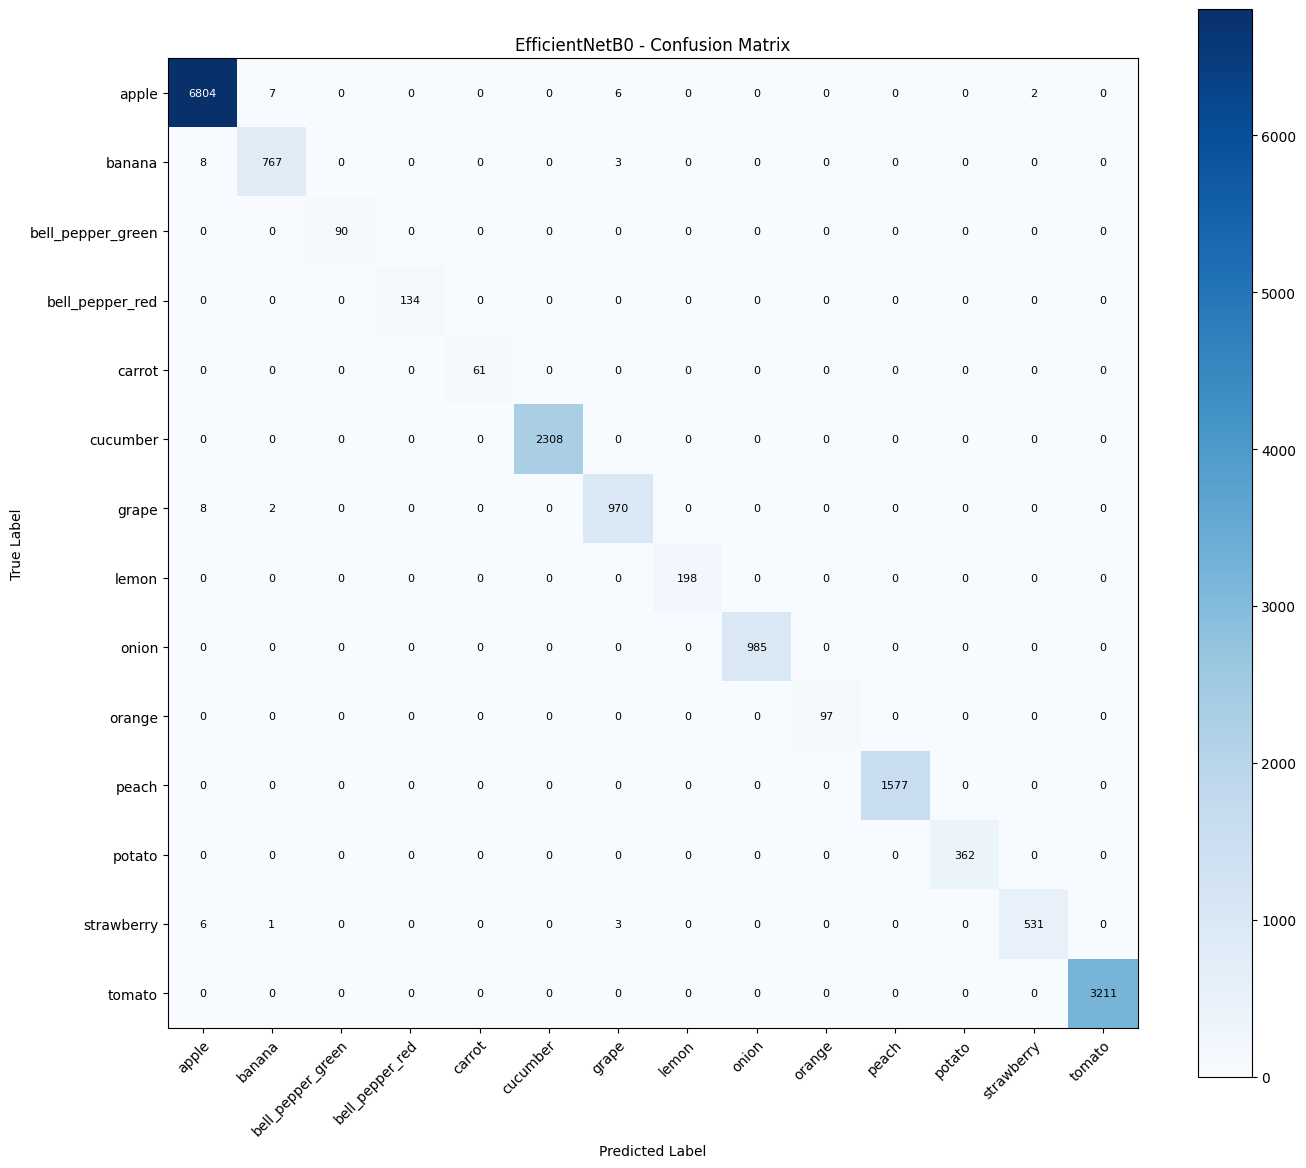


Saved: /content/efficientnet_confusion_matrix.png


In [14]:
# ============================================================================
# CONFUSION MATRIX
# ============================================================================
# Visualises classification performance per class.
# ============================================================================

print("=" * 70)
print("CONFUSION MATRIX")
print("=" * 70)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(CLASS_NAMES)),
    yticks=np.arange(len(CLASS_NAMES)),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='EfficientNetB0 - Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=8)

plt.tight_layout()
plt.savefig('/content/efficientnet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/efficientnet_confusion_matrix.png")

TRAINING HISTORY


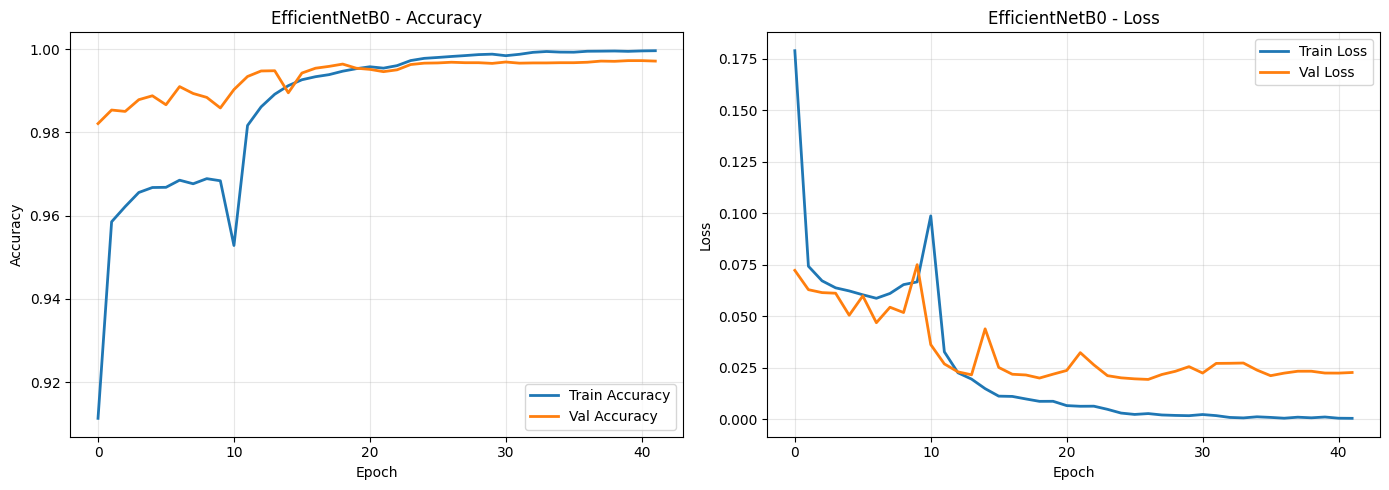


Saved: /content/efficientnet_training_history.png

[Best Validation Performance]
  Epoch:    40
  Accuracy: 99.72%


In [15]:
# ============================================================================
# TRAINING HISTORY PLOTS
# ============================================================================
# Visualises accuracy and loss curves over ALL training epochs
# (including any resumed sessions).
# ============================================================================

print("=" * 70)
print("TRAINING HISTORY")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('EfficientNetB0 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('EfficientNetB0 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/efficientnet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/efficientnet_training_history.png")

# Print best metrics
best_epoch = np.argmax(history['val_accuracy']) + 1
best_val_acc = max(history['val_accuracy'])
print(f"\n[Best Validation Performance]")
print(f"  Epoch:    {best_epoch}")
print(f"  Accuracy: {best_val_acc*100:.2f}%")

In [16]:
# ============================================================================
# INFERENCE BENCHMARK
# ============================================================================
# Measures inference speed for single image and batch processing.
# ============================================================================

print("=" * 70)
print("INFERENCE BENCHMARK")
print("=" * 70)

# Create test batch
test_batch, _ = next(iter(test_generator))
single_image = test_batch[0:1]

# Warmup
for _ in range(5):
    _ = best_model.predict(single_image, verbose=0)

# Single image inference (100 iterations)
print("\nBenchmarking single image inference...")
times_single = []
for _ in range(100):
    start = time.time()
    _ = best_model.predict(single_image, verbose=0)
    times_single.append((time.time() - start) * 1000)

INFERENCE_TIME_SINGLE = np.mean(times_single)
INFERENCE_STD_SINGLE = np.std(times_single)

# Batch inference (32 images, 20 iterations)
print("Benchmarking batch inference...")
times_batch = []
for _ in range(20):
    start = time.time()
    _ = best_model.predict(test_batch, verbose=0)
    times_batch.append((time.time() - start) * 1000 / len(test_batch))

INFERENCE_TIME_BATCH = np.mean(times_batch)
INFERENCE_STD_BATCH = np.std(times_batch)

print(f"""
[Inference Results]
  Single Image:      {INFERENCE_TIME_SINGLE:.2f} +/- {INFERENCE_STD_SINGLE:.2f} ms
  Batch (per image): {INFERENCE_TIME_BATCH:.2f} +/- {INFERENCE_STD_BATCH:.2f} ms
""")

INFERENCE BENCHMARK

Benchmarking single image inference...
Benchmarking batch inference...

[Inference Results]
  Single Image:      68.70 +/- 2.61 ms
  Batch (per image): 14.10 +/- 43.15 ms



In [17]:
# ============================================================================
# SAVE MODEL AND RESULTS
# ============================================================================
# Saves final model and comprehensive results JSON for comparison.
# ============================================================================

print("=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save model
MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/efficientnet_model.keras"
print(f"\nSaving model to: {MODEL_SAVE_PATH}")
best_model.save(MODEL_SAVE_PATH)
print("Model saved.")

model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# Compile results
results = {
    "model_name": "EfficientNetB0",
    "architecture": {
        "type": "Transfer Learning",
        "base_model": "EfficientNetB0",
        "pretrained_on": "ImageNet",
        "base_layers": len(base_model.layers),
        "fine_tuned_from_layer": fine_tune_from,
        "fine_tuned_layers": len(base_model.layers) - fine_tune_from,
        "dropout": 0.3,
        "input_size": list(IMG_SIZE),
        "num_classes": NUM_CLASSES
    },
    "training": {
        "phase1_epochs": PHASE1_EPOCHS,
        "total_epochs": len(history['loss']),
        "best_epoch": int(np.argmax(history['val_accuracy']) + 1),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "image_size": list(IMG_SIZE),
        "used_class_weights": True,
        "augmentation": AUGMENTATION_CONFIG
    },
    "performance": {
        "best_val_accuracy": float(max(history['val_accuracy'])),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss)
    },
    "per_class_metrics": {
        class_name: {
            "precision": float(report_dict[class_name]["precision"]),
            "recall": float(report_dict[class_name]["recall"]),
            "f1_score": float(report_dict[class_name]["f1-score"]),
            "support": int(report_dict[class_name]["support"])
        }
        for class_name in CLASS_NAMES
    },
    "efficiency": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# Save results JSON
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/efficientnet_results.json"
print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved.")

# Copy plots
print("\nCopying plots to Drive...")
shutil.copy('/content/efficientnet_training_history.png', f"{DRIVE_MODEL_DIR}/efficientnet_training_history.png")
shutil.copy('/content/efficientnet_confusion_matrix.png', f"{DRIVE_MODEL_DIR}/efficientnet_confusion_matrix.png")
print("Plots saved.")

SAVING MODEL AND RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models_v2/efficientnet_model.keras
Model saved.

Saving results to: /content/drive/MyDrive/snapshelf_models_v2/efficientnet_results.json
Results saved.

Copying plots to Drive...
Plots saved.


In [18]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("=" * 70)
print("EfficientNetB0 - FINAL SUMMARY")
print("=" * 70)

print(f"""
MODEL: EfficientNetB0
--------------------------------------------------
Type:           Transfer Learning
Base Model:     EfficientNetB0 (ImageNet)
Fine-Tuned:     top 30% of base layers
Dropout:        0.3
Pretrained:     Yes (ImageNet)

TRAINING
--------------------------------------------------
Phase 1 Epochs:    {PHASE1_EPOCHS}
Total Epochs:      {len(history['loss'])}
Best Epoch:        {np.argmax(history['val_accuracy']) + 1}
Training Time:     {training_duration}

PERFORMANCE
--------------------------------------------------
Validation Accuracy: {max(history['val_accuracy'])*100:.2f}%
Test Accuracy:       {test_accuracy*100:.2f}%
Test Loss:           {test_loss:.4f}

EFFICIENCY
--------------------------------------------------
Total Parameters:    {total_params:,}
Trainable Params:    {trainable_params:,}
Model Size:          {model_size_mb:.2f} MB
Inference (single):  {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):   {INFERENCE_TIME_BATCH:.2f} ms/image

OUTPUT FILES
--------------------------------------------------
Model:   {MODEL_SAVE_PATH}
Results: {RESULTS_PATH}
Plots:   {DRIVE_MODEL_DIR}/efficientnet_*.png
""")

print("=" * 70)
print("EfficientNetB0 TRAINING COMPLETE")
print("=" * 70)

EfficientNetB0 - FINAL SUMMARY

MODEL: EfficientNetB0
--------------------------------------------------
Type:           Transfer Learning
Base Model:     EfficientNetB0 (ImageNet)
Fine-Tuned:     top 30% of base layers
Dropout:        0.3
Pretrained:     Yes (ImageNet)

TRAINING
--------------------------------------------------
Phase 1 Epochs:    10
Total Epochs:      42
Best Epoch:        40
Training Time:     39458s (657.6 min)

PERFORMANCE
--------------------------------------------------
Validation Accuracy: 99.72%
Test Accuracy:       99.75%
Test Loss:           0.0207

EFFICIENCY
--------------------------------------------------
Total Parameters:    4,072,625
Trainable Params:    3,099,626
Model Size:          40.03 MB
Inference (single):  68.70 ms
Inference (batch):   14.10 ms/image

OUTPUT FILES
--------------------------------------------------
Model:   /content/drive/MyDrive/snapshelf_models_v2/efficientnet_model.keras
Results: /content/drive/MyDrive/snapshelf_models_v2/e